# 德国交通标志分类—基于卷积神经网络（LeNet）算法

此项目来自优达学城-自动驾驶车辆课程项目，实现方法通过卷积神经网络（LeNet）算法。整个项目分为以下几部分：

- 数据导入与分析
- 搭建卷积神经网络模型实现
- 测试集上验证识别效果
- 可视化显示不同卷积层结果

# 数据导入与分析

本项目用到的交通标图片来源于网站：[German Traffic Sign Benchmarks](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset)

项目中用到的图片压缩包文件下载地址为，需要下载并解压：
- https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
- https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
- https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip


## 训练集数据文件夹结构

解压GTSRB_Final_Training_Images.zip文件到指定位置。得到文件夹结构：...\GTSRB\Final_Training\Images\...
训练集（Training）中图片总共有43种交通标志，对应解压后的...\Images文件夹下的43个子文件夹。每一个文件夹内的图片(.ppm格式)对应一种类型的交通标志（例如stop single），同时每一个文件夹内有一个.CSV问价存储记录了图片文件的相关信息。文件夹结构如下：

```
Training_Images
    + GTSRB
     + Final_Training
        + Images
            + 00000
                + 00000_00000.ppm
                + 00000_00001.ppm
                ...    
                + GT-00000.csv
            + 00001
                + 00000_00000.ppm
                + 00000_00001.ppm
                ...    
                + GT-00001.csv
            ...
```
注意：所有的图片格式为[PPM](https://blog.csdn.net/kinghzkingkkk/article/details/70226214)格式。需要借助Python的 `matplotlib` 与 `pillow` 库进行图片处理。如果想直接打开查看图片可能需要借助[其他软件](http://www.4qx.net/Extension_DaQuan.php?name=ppm)。

## 导入需要的库

In [1]:
import glob
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from sklearn.utils import shuffle

from tensorflow.contrib.layers import flatten

matplotlib.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 导入训练集数据

为了方便起见，将所有的列车图像路径合并到一个dataframe

In [2]:
TRAIN_IMAGE_DIR = 'Training_Images\GTSRB\Final_Training\Images' #此处为文件夹地址
dfs = []                                                        #创建空list用于存储数据
for train_file in glob.glob(os.path.join(TRAIN_IMAGE_DIR, '*/GT-*.csv')):
    '''
    循环读取\Images文件夹下，每一个子文件夹内的csv问价并存储到dfs中
    '''
    folder = train_file.split('\\')[4]                         #对地址进行分割得到Images文件夹下的0000/0001...子文件夹名
    df = pd.read_csv(train_file, sep=';')                     #读取文件夹中csv文件
    df['Filename'] = df['Filename'].apply(lambda x: os.path.join(TRAIN_IMAGE_DIR, folder, x))#将‘Filename'列内容延展，增加文件地址
    dfs.append(df)                                             #添加df到dfs列表

In [3]:
train_df = pd.concat(dfs, ignore_index=True)                 #将dfs中的数据进行拼接成dataframe存储到train_df
train_df.head()                                              #查看dfs数据前5行

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
0,Training_Images\GTSRB\Final_Training\Images\00...,29,30,5,6,24,25,0
1,Training_Images\GTSRB\Final_Training\Images\00...,30,30,5,5,25,25,0
2,Training_Images\GTSRB\Final_Training\Images\00...,30,30,5,5,25,25,0
3,Training_Images\GTSRB\Final_Training\Images\00...,31,31,5,5,26,26,0
4,Training_Images\GTSRB\Final_Training\Images\00...,30,32,5,6,25,26,0


**数据注释**
- Filename: 对应的图片文件名（增加了地址信息）
- Width: 图片宽度（像素）
- Height: 图片高度（像素）
- ROI.x1: 交通标志图像左上角位置的X轴坐标信息
- ROI.y1: 交通标志图像左上角位置的Y轴坐标信息
- ROI.x2: 交通标志图像右下角位置的X轴坐标信息
- ROI.y2: 交通标志图像右下角位置的Y轴坐标信息
- ClassId: 图片的类标签（0~42）

通过读取的图片信息可以发现以下几点：
- 图片的大小不固定
- 交通标志图像的大小不固定
- 交通标志中心的位置不固定

这几点是后续处理中需要注意的地方。

## 查看标志分类分布情况
训练集中总共有39209个图片，43种标志分类

In [4]:
N_CLASSES = np.unique(train_df['ClassId']).size                       #通过统计ClassId不同值的个数，得到交通标志分类数量

print("Number of training images : {:>5}".format(train_df.shape[0]))  #训练集图片数量
print("Number of classes         : {:>5}".format(N_CLASSES))          #训练集交通标志分类数量

Number of training images : 39209
Number of classes         :    43


In [5]:
def show_class_distribution(classIDs, title):
    """
    画直方图显示样本集中交通信号的分布情况
    """
    plt.figure(figsize=(15, 5))
    plt.title('Class ID distribution for {}'.format(title))
    plt.hist(classIDs, bins=N_CLASSES)   #画直方图
    plt.show()

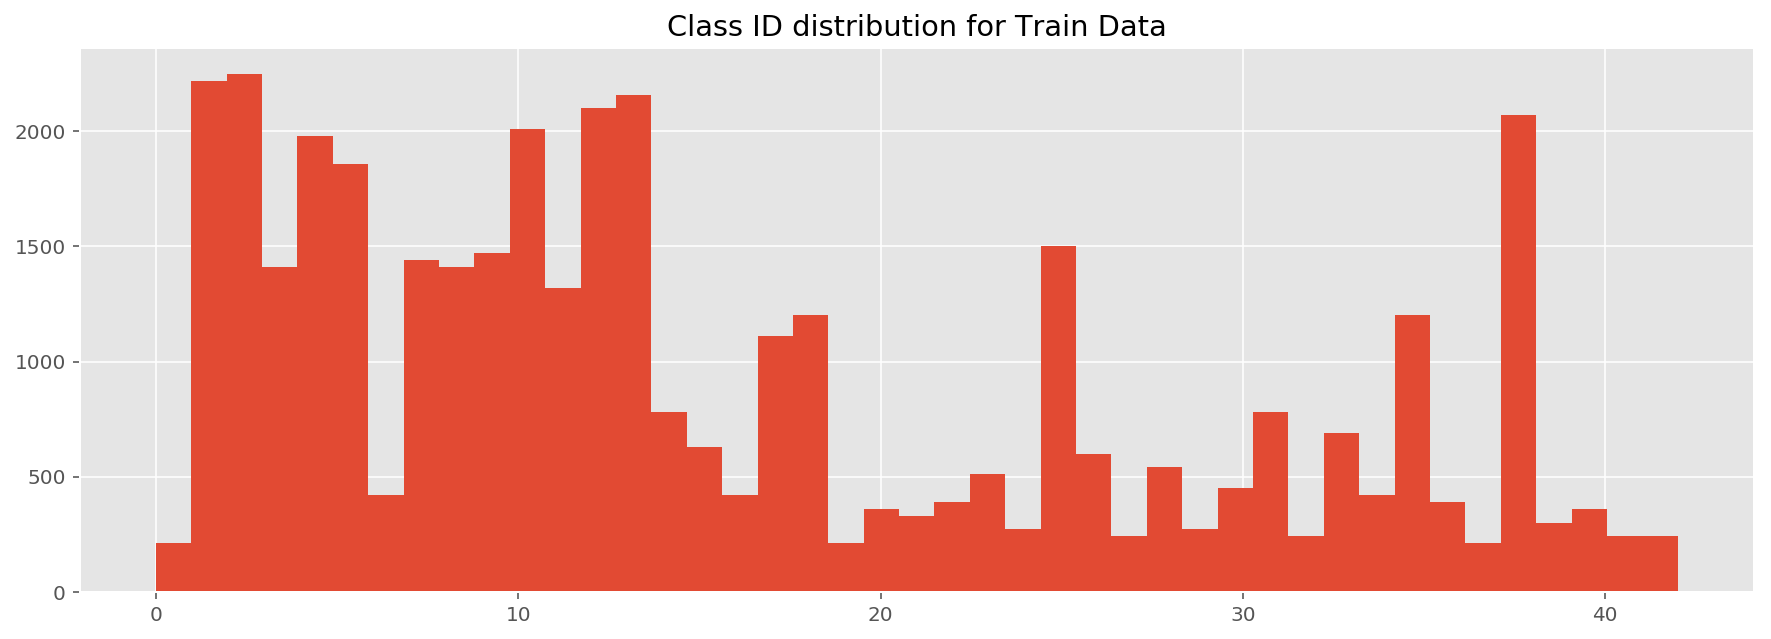

In [6]:
show_class_distribution(train_df['ClassId'], 'Train Data') #调取画图函数，绘制样本集中交通信号的分布情况

上图的分布图中横坐标为信号分类为数字代码（0-42），同时每一个代码对应的名称存储在sign_names.csv文件。下面将导入文件，通过交通信号名称更直观的查看分布情况。

In [7]:
sign_name_df = pd.read_csv('signnames.csv', index_col='ClassId')    #读取signnames.csv文件并存储数据
sign_name_df.head()                                                 #查看数据前5行

,SignName
ClassId,
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)


In [8]:
sign_name_df['Occurence'] = [sum(train_df['ClassId']==c) for c in range(N_CLASSES)]#计算每一个图标的出现数量
sign_name_df.sort_values('Occurence', ascending=False)                             #按照交通信号出现次数降序排列

,SignName,Occurence
ClassId,,
2,Speed limit (50km/h),2250
1,Speed limit (30km/h),2220
13,Yield,2160
12,Priority road,2100
38,Keep right,2070
10,No passing for vehicles over 3.5 metric tons,2010
4,Speed limit (70km/h),1980
5,Speed limit (80km/h),1860
25,Road work,1500


In [9]:
SIGN_NAMES = sign_name_df.SignName.values  #获取交通标志名称，存储在SIGN_NAMES。后面程序会多次用到。
SIGN_NAMES[2]                              #查看ClassId为2的交通标志名称

'Speed limit (50km/h)'

## 图片查看

从样本集随机抽取部分图片查看:

In [10]:
def load_image(image_file):
    """
    读取图片
    """
    return plt.imread(image_file) #image-read 读取图片

In [11]:
def get_samples(image_data, num_samples, class_id=None):
    """
    随机抽取图片函数
    函数输出：随机抽取的图片的[路径，分类]信息
    函数输入：
    image_data，全部的图片文件
    num_samples，随机抽取的图片个数
    class_id=None时候不指定图片中标志分类，否则将按照指定的标志随机选取图片
    """
    if class_id is not None:
        image_data = image_data[image_data['ClassId']==class_id]      #指定固定的交通标志ClassId
    indices = np.random.choice(image_data.shape[0], size=num_samples, replace=False)#随机抽取num_samples个图片
    
    return image_data.iloc[indices][['Filename', 'ClassId']].values  #输出数据格式['Filename', 'ClassId']组成的array

In [12]:
def show_images(image_data, cols=5, sign_names=None, show_shape=False, func=None):
    """
    Given a list of image file paths, load images and show them.
    显示给定路径的图片，路径通过get_samples函数获得
    """
    num_images = len(image_data)
    rows = num_images//cols
    plt.figure(figsize=(cols*3,rows*3))
    for i, (image_file, label) in enumerate(image_data):        
#     (image_file, label)对应['Filename', 'ClassId']，后面有用到label显示交通标志名称。
#     enumerate() 函数用于将一个可遍历的数据对象(如列表、元组或字符串)组合为一个索引序列，
#     同时列出数据和数据下标，一般用在 for 循环当中。
    
        image = load_image(image_file)
        if func is not None:
            image = func(image)
        plt.subplot(rows, cols, i+1)
        plt.imshow(image)
        
        if sign_names is not None:#显示signl名称,在原图片的左上角
            plt.text(0, 0, '{}: {}'.format(label, sign_names[label]), color='k',backgroundcolor='c', fontsize=8)        
        
        if show_shape:            #显示图片shape，在原图片的左下角
            plt.text(0, image.shape[0], '{}'.format(image.shape), color='k',backgroundcolor='y', fontsize=8)        
        plt.xticks([])
        plt.yticks([])
    plt.show()

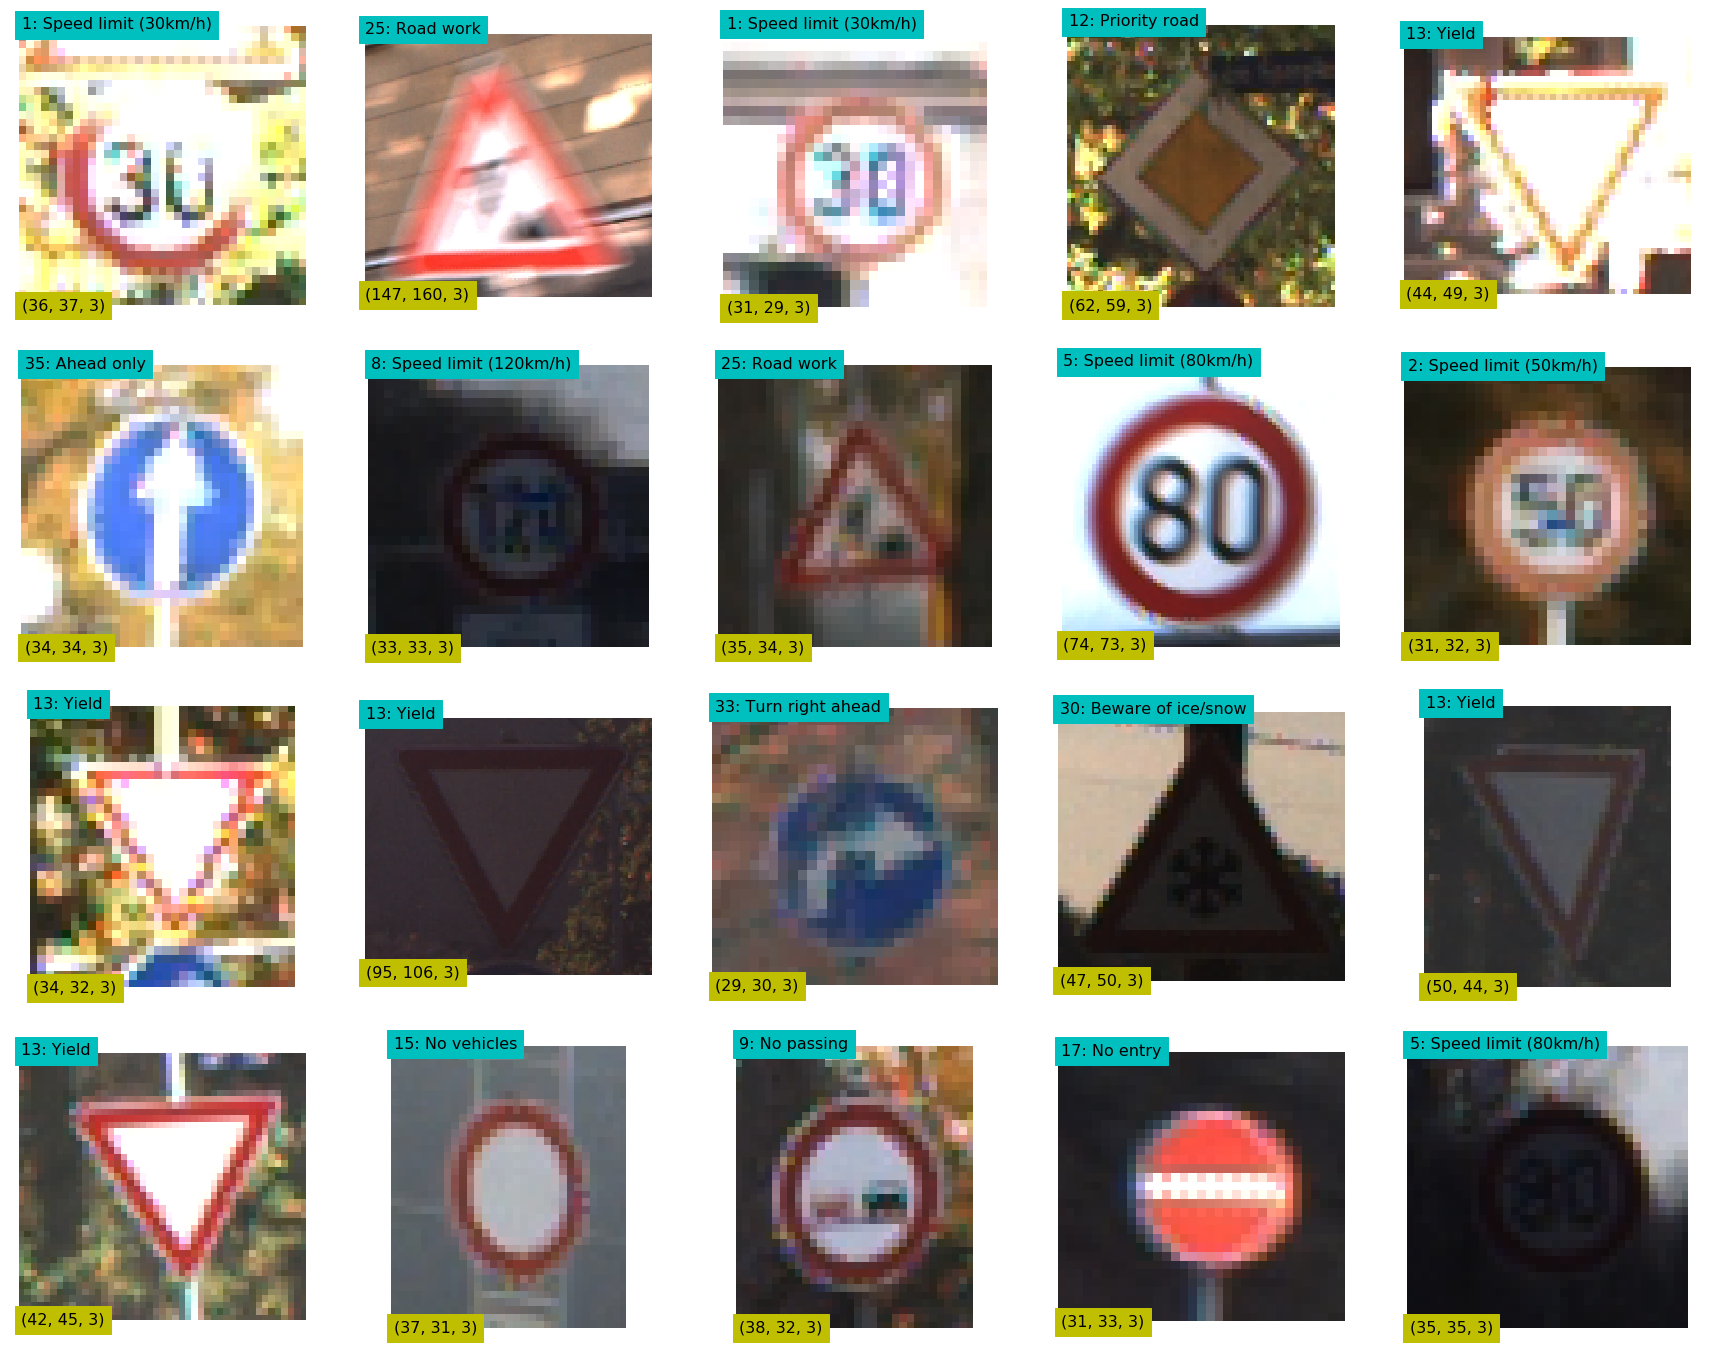

In [13]:
sample_data = get_samples(train_df, 20)
show_images(sample_data, sign_names=SIGN_NAMES, show_shape=True)
#sign_names,用来显示数据label

Speed limit (60km/h)


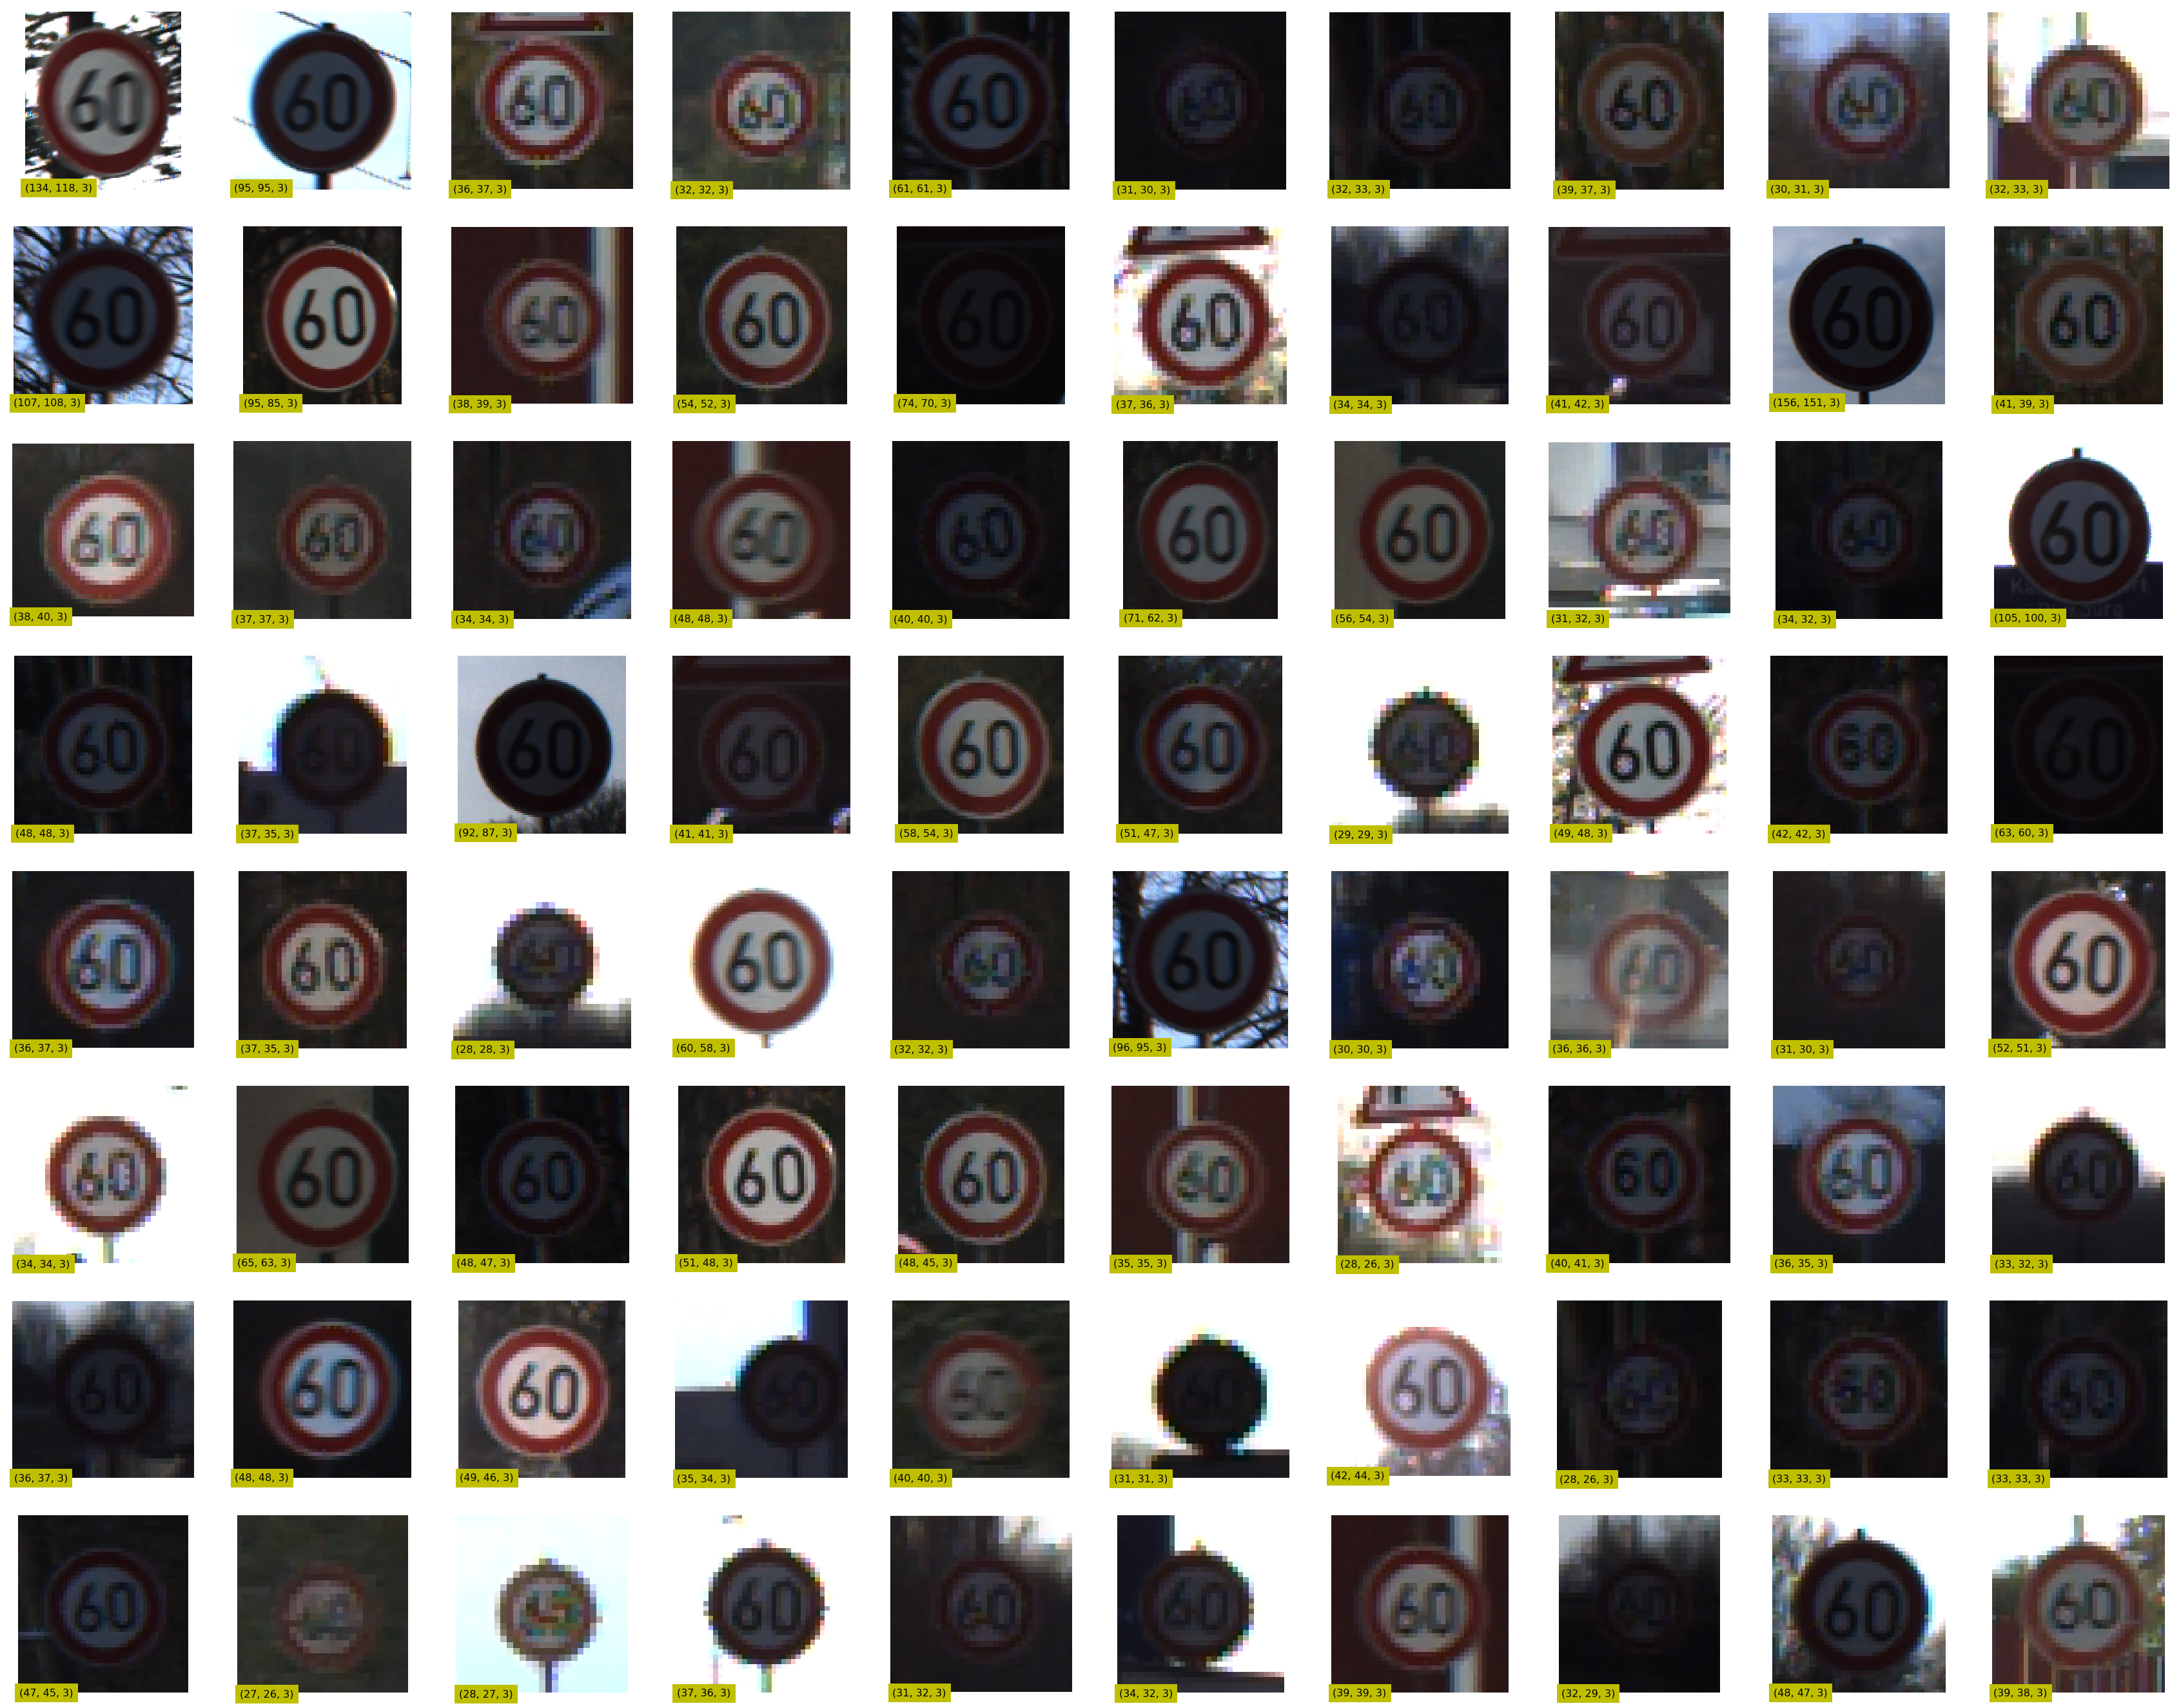

In [14]:
print(SIGN_NAMES[3])
show_images(get_samples(train_df, 80, class_id=3), cols=10, show_shape=True)

通过对样本图像的分析，可以发现图像有如下特征:

- 图像尺寸不统一
- 图像的亮度不统一
- 图像可能存在一定角度旋转
- 图像可能存在一定程度倾斜（不正对镜头）
- 交通标志位置可能不在正中心
  
下面将对图片尺寸进行调整，调整为统一尺寸。

## 设置训练集与验证集数据

设置训练集和验证集数据。

In [15]:
def resize_image(image_file, shape=(32,32)):
    """
    函数，读取图片并调整图片尺寸为（32，32）
    输入：图片文件地址
    输出：np.array存储的调整后的图片文件
    """
    image_list=[]
    for image_file_n in image_file:
        image_file_n
        image=load_image(image_file_n)
        image=cv2.resize(image, shape)
        image_list.append(image)
    image=np.array(image_list)
    return image

In [16]:
X = resize_image(train_df['Filename'].values) #读取图片并调整尺寸
y = train_df['ClassId'].values                #读取分类label数据
X, y = shuffle(X, y)                          #元素随机排序
print('X data', len(X))

X data 39209


In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=0.25, random_state=0)
#通过train_test_split函数，切割得到训练集和测试集

print('X_train:', len(X_train))
print('X_valid:', len(X_valid))

X_train: 29406
X_valid: 9803


# 模型实现
## LeNet-5 模型架构

这里用到的时是[LeNet-5](http://www.tensornews.cn/lenet/)模型。它是第一个成功应用于数字识别问题的卷积神经网络。LeNet-5模型结构图如下：

![LeNet](lenet.png)

来源: http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf

针对本项目，这里用到的模型在在原始LeNet模型基础上有调整：

### 输入

输入为32x32x3(RGB - 3通道)图片

### 架构
第一层：
- 卷积，输出节点矩阵为28x28x6;
- 激活函数：ReLU；
- 池化，过滤器大小为2x2,长宽步长为2，输出矩阵大小为14x14x6

第二层：
- 卷积，输出节点矩阵为10x10x16;
- 激活函数：ReLU；
- 池化，过滤器大小为2x2,长宽步长为2，输出矩阵大小为5x5x16
- Flatten

第三层：
- 全连接（Fully Connected），输出节点个数为120;
- 激活函数：ReLU；

第四层：
- 全连接（Fully Connected），输出节点个数为84;
- 激活函数：ReLU；

第五层：
- 全连接（Fully Connected）.输出节点个数为43

### 输出

第二次全连接之后的43种交通标志分类

|Layer                       | Shape    |
|----------------------------|:--------:|
|Input                       | 32x32x3  |
|Convolution (valid, 5x5x6)  | 28x28x6  |
|Max Pooling (valid, 2x2)    | 14x14x6  |
|Activation  (ReLU)          | 14x14x6  |
|Convolution (valid, 5x5x16) | 10x10x16 |
|Max Pooling (valid, 2x2)    | 5x5x16   |
|Activation  (ReLU)          | 5x5x16   |
|Flatten                     | 400      |
|Dense                       | 120      |
|Activation  (ReLU)          | 120      |
|Dense                       | 43       |
|Activation  (Softmax)       | 43       |

In [18]:
def LeNet(x):    
    # 超参数设置/Hyperparameters
    mu = 0
    sigma = 0.01
    keep_prob = 1
    
    # 第一层: 卷积. 输入 = 32x32x3. 输出 = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    # 激活函数
    active1 = tf.nn.relu(conv1)
    # 池化（Pooling）：输入 = 28x28x6. 输出 = 14x14x6.
    pool1 = tf.nn.max_pool(active1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # 第二层: 卷积. 输出 = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(pool1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    # 激活函数
    active2 = tf.nn.relu(conv2)
    # 池化（Poolin）：输入 = 10x10x16. 输出 = 5x5x16.
    pool2 = tf.nn.max_pool(active2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    # Flatten. 输入 = 5x5x16. 输出 = 400.
    fc0   = flatten(pool2)
    
    # 第三层: 全连接（Fully Connected）.输入= 400. 输出 = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    # 激活函数
    fc1    = tf.nn.relu(fc1)

    # 第四层: 全连接（Fully Connected）. 输入 = 120. 输出 = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    # 激活函数.
    fc2    = tf.nn.relu(fc2)
    fc2    = tf.nn.dropout(fc2, keep_prob)

    # 第五层: 全连接（Fully Connected）. 输入= 84. 输出 = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits, {'conv1': conv1, 'conv2': conv2, 'activ1': active1, 'activ2': active2, 'pool1': pool1}

## 特征与标签

训练LeNet网络对输入数据进行分类

x是输入图像的占位符。
y是输出标签的占位符。

In [19]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

In [20]:
# 模型训练
rate = 0.001

logits, layers = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation) 

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [21]:
def evaluate(X_data, y_data):

    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples 

In [22]:
model_name = 'lenet_report'       #设置模型名称，后续对结果保存时候会用到

EPOCHS = 15                       #设置周期 (Epochs)
BATCH_SIZE = 150                 #设置批大小（批尺寸)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        n_train_right = 0
        
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            n_train_right += sess.run(accuracy_operation,feed_dict={x: batch_x, y: batch_y}) * len(y_train[offset:end])
        
        train_accuracy = n_train_right/num_examples
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Train      Accuracy = {:.3f}".format(train_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './models/'+model_name)
    print("Model saved")

Training...

EPOCH 1 ...
Train      Accuracy = 0.109
Validation Accuracy = 0.340

EPOCH 2 ...
Train      Accuracy = 0.588
Validation Accuracy = 0.726

EPOCH 3 ...
Train      Accuracy = 0.852
Validation Accuracy = 0.886

EPOCH 4 ...
Train      Accuracy = 0.922
Validation Accuracy = 0.926

EPOCH 5 ...
Train      Accuracy = 0.946
Validation Accuracy = 0.941

EPOCH 6 ...
Train      Accuracy = 0.959
Validation Accuracy = 0.950

EPOCH 7 ...
Train      Accuracy = 0.968
Validation Accuracy = 0.955

EPOCH 8 ...
Train      Accuracy = 0.975
Validation Accuracy = 0.942

EPOCH 9 ...
Train      Accuracy = 0.974
Validation Accuracy = 0.955

EPOCH 10 ...
Train      Accuracy = 0.981
Validation Accuracy = 0.960

EPOCH 11 ...
Train      Accuracy = 0.985
Validation Accuracy = 0.971

EPOCH 12 ...
Train      Accuracy = 0.987
Validation Accuracy = 0.974

EPOCH 13 ...
Train      Accuracy = 0.988
Validation Accuracy = 0.974

EPOCH 14 ...
Train      Accuracy = 0.989
Validation Accuracy = 0.963

EPOCH 15 ...
Tra

# 实现效果验证分析
导入测试数据集之外新的图片验证识别准确率

## 测试集数据

测试图片位于文件夹Test_Images/GTSRB/Final_Test内

```
Test_Images
    +GTSRB
         + Final_Test
            + Images
                + 00000.ppm
                + 00001.ppm
                + ...
                + GT-final_test.csv      # 扩展的注释，包括图片分类id
                + GT-final_test.test.csv
```
GT-final_test.csv文件是单独下载，包含测试集图片label信息

In [23]:
Test_IMAGE_DIR = 'Test_Images\GTSRB\Final_Test' #此处为文件夹地址

test_file=glob.glob(os.path.join(Test_IMAGE_DIR, '*/GT-*.csv'))
folder = test_file[0].split('\\')[3]
test_df = pd.read_csv(test_file[0], sep=';')                     #读取文件夹中csv文件
test_df['Filename'] = test_df['Filename'].apply(lambda x: os.path.join(Test_IMAGE_DIR,folder, x))#将‘Filename'列内容延展，增加文件地址

In [24]:
print("Number of test images: {:>5}".format(test_df.shape[0]))

Number of test images: 12630


In [25]:
X_test = resize_image(test_df['Filename'].values) #读取图片并调整尺寸
y_test = test_df['ClassId'].values                #读取分类label数据

In [26]:
test_df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
0,Test_Images\GTSRB\Final_Test\Images\00000.ppm,53,54,6,5,48,49,16
1,Test_Images\GTSRB\Final_Test\Images\00001.ppm,42,45,5,5,36,40,1
2,Test_Images\GTSRB\Final_Test\Images\00002.ppm,48,52,6,6,43,47,38
3,Test_Images\GTSRB\Final_Test\Images\00003.ppm,27,29,5,5,22,24,33
4,Test_Images\GTSRB\Final_Test\Images\00004.ppm,60,57,5,5,55,52,11


In [27]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./models'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./models\lenet_report
Test Accuracy = 0.907


# 可视化
- 可视化显示CNN神经网络不同层的输出

In [36]:
def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('./models'))
        activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
        featuremaps = activation.shape[3]
        plt.figure(plt_num, figsize=(15,3))
        for featuremap in range(min(featuremaps, 16)):
            plt.subplot(2,8, featuremap+1) 
            plt.title('FeatureMap ' + str(featuremap))
            if activation_min != -1 & activation_max != -1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
            elif activation_max != -1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
            elif activation_min !=-1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
            else:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

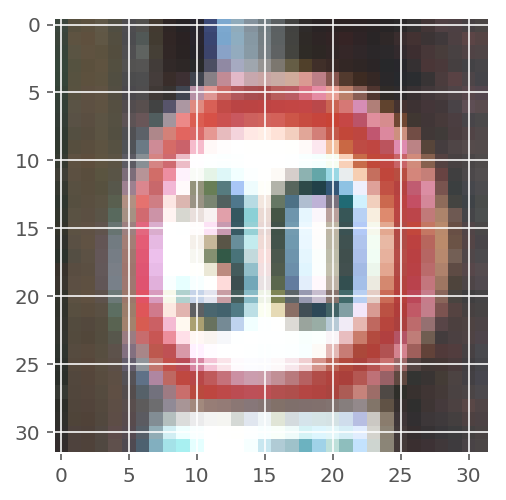

In [37]:
test_im = X_test[1]
plt.imshow(test_im)

First convolutional layer feature map:
INFO:tensorflow:Restoring parameters from ./models\lenet_report


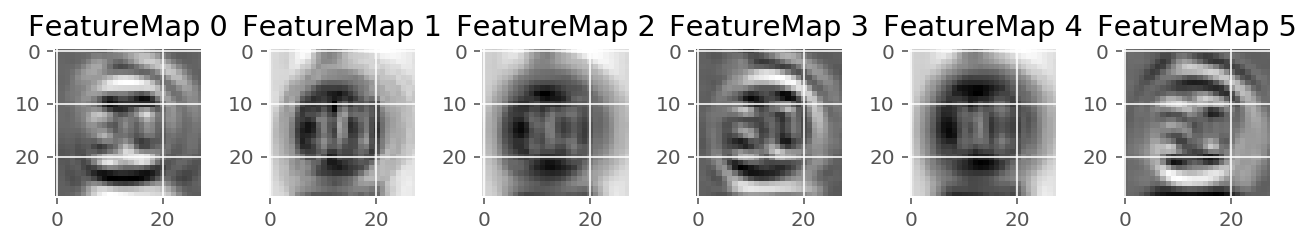

In [38]:
image_input = np.expand_dims(test_im, 0)
print("First convolutional layer feature map:")
outputFeatureMap(image_input, layers['conv1'])
plt.savefig('writeup_imgs/conv1.jpg')

First convolutional layer feature map:
INFO:tensorflow:Restoring parameters from ./models\lenet_report


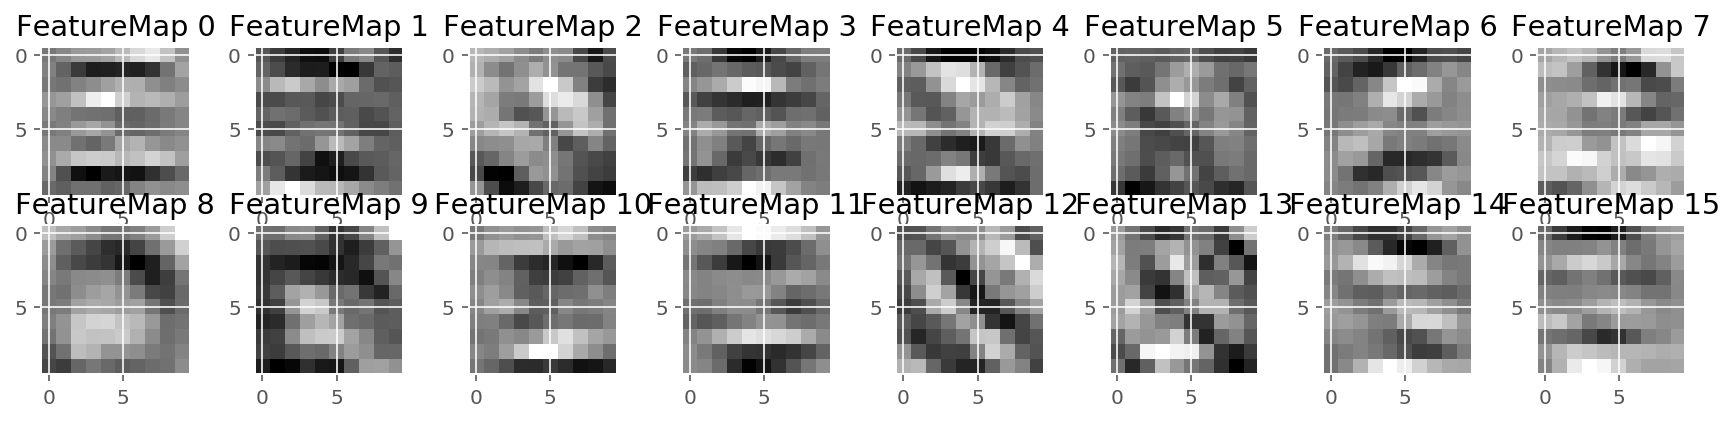

In [39]:

image_input = np.expand_dims(test_im, 0)
print("First convolutional layer feature map:")
outputFeatureMap(image_input, layers['conv2'])
plt.savefig('writeup_imgs/conv2.jpg')